In [1]:
import duckdb
import pandas as pd
import numpy as np

real_db = "real_data.duckdb"
synth_db = "outputs/synthetic_data.duckdb"

real_con = duckdb.connect(real_db, read_only=True)
synth_con = duckdb.connect(synth_db, read_only=True)

real = real_con.execute("SELECT * FROM train_guid;").df()  # created by the training script in real DB
synth = synth_con.execute("SELECT * FROM train_guid_synth;").df()

print(real.shape, synth.shape)
real.head()

(56473, 14) (50000, 14)


,guid,os,chassistype,vendor,ram,number_of_cores,received_bytes,sent_bytes,net_nr_samples,frgnd_total_duration_sec,frgnd_total_nrs,frgnd_rows,userwait_total_duration_ms,userwait_rows
0,030c0e35988f4ed8a1cda4442b48185f,Win11,Notebook,Lenovo,8.0,4,1.775340e+11,1.298411e+10,277100,447180.0,86707,384,24728309,178
1,030d91c232ea4af095df25560e6b45ee,Win10,Notebook,Asus,32.0,4,2.931005e+14,7.256178e+12,11526914,111706920.0,22272806,149029,13712166750,14771
2,033a969340584cfbb36ee9fc0c06532f,Win11,Desktop,Asus,64.0,12,1.255532e+12,1.820051e+11,5019275,24158848.0,4595586,77625,13967390060,15044
3,06408cbd701549c686990ab910154c5a,Win11,2 in 1,HP,16.0,6,1.577220e+12,8.824922e+11,4894574,23144382.0,4614038,177370,9434446943,21831
4,06448d73b8104d6f96dec3129ec28caf,Win10,Notebook,Apple,8.0,2,4.238124e+10,1.822178e+09,117260,565646.0,113019,1645,137485742,472


In [2]:
def summarize(df):
    return pd.DataFrame({
        "dtype": df.dtypes.astype(str),
        "missing_frac": df.isna().mean(),
        "n_unique": df.nunique(dropna=True)
    }).sort_values("missing_frac", ascending=False)

summarize(real).head(20)

,dtype,missing_frac,n_unique
number_of_cores,Int64,0.03074,16
guid,object,0.00000,56473
os,object,0.00000,5
chassistype,object,0.00000,7
vendor,object,0.00000,48
ram,float64,0.00000,36
received_bytes,float64,0.00000,37134
sent_bytes,float64,0.00000,37003
net_nr_samples,int64,0.00000,36610
frgnd_total_duration_sec,float64,0.00000,7943


In [3]:
from scipy.stats import ks_2samp, wasserstein_distance

num_cols = [c for c in real.columns if pd.api.types.is_numeric_dtype(real[c]) and c in synth.columns]

rows = []
for c in num_cols:
    r = pd.to_numeric(real[c], errors="coerce").dropna().to_numpy()
    s = pd.to_numeric(synth[c], errors="coerce").dropna().to_numpy()
    if len(r) < 2 or len(s) < 2:
        continue
    rows.append({
        "col": c,
        "real_mean": float(np.mean(r)),
        "synth_mean": float(np.mean(s)),
        "real_std": float(np.std(r)),
        "synth_std": float(np.std(s)),
        "ks": float(ks_2samp(r, s).statistic),
        "wasserstein": float(wasserstein_distance(r, s)),
    })

metrics = pd.DataFrame(rows).sort_values("ks", ascending=False)
metrics

,col,real_mean,synth_mean,real_std,synth_std,ks,wasserstein
0,ram,1.238149e+01,1.816636e+01,1.388728e+01,1.298279e+01,0.375564,6.206766e+00
1,number_of_cores,3.773042e+00,3.837820e+00,1.955371e+00,1.269692e+00,0.245170,6.355262e-01
2,received_bytes,4.746989e+15,2.068794e+12,7.513488e+17,1.000733e+14,0.180920,4.747323e+15
3,sent_bytes,4.746702e+15,1.461438e+11,7.513489e+17,4.712733e+12,0.179347,4.746580e+15
8,userwait_total_duration_ms,1.000292e+09,5.532951e+08,2.948114e+09,1.452782e+09,0.130769,4.469973e+08
4,net_nr_samples,1.235499e+06,6.700056e+05,2.291935e+06,1.303854e+06,0.101469,5.654968e+05
5,frgnd_total_duration_sec,1.326547e+06,3.964636e+05,9.457777e+06,6.026948e+06,0.094205,9.300839e+05
6,frgnd_total_nrs,2.525112e+05,6.995905e+04,1.828166e+06,1.053903e+06,0.092338,1.825522e+05
7,frgnd_rows,3.728184e+03,6.091369e+02,2.854321e+04,9.198537e+03,0.084685,3.119047e+03
9,userwait_rows,3.102790e+03,1.546848e+03,2.158825e+04,4.229611e+03,0.080871,1.556165e+03


In [4]:
def freq_l1(a, b):
    a = a.fillna("MISSING").astype(str)
    b = b.fillna("MISSING").astype(str)
    fa = a.value_counts(normalize=True)
    fb = b.value_counts(normalize=True)
    idx = fa.index.union(fb.index)
    return float(np.abs(fa.reindex(idx, fill_value=0) - fb.reindex(idx, fill_value=0)).sum())

cat_cols = [c for c in ["os", "chassistype", "vendor"] if c in real.columns and c in synth.columns]
cat_eval = pd.DataFrame([{
    "col": c,
    "freq_l1": freq_l1(real[c], synth[c]),
    "real_unique": int(real[c].nunique(dropna=True)),
    "synth_unique": int(synth[c].nunique(dropna=True)),
} for c in cat_cols]).sort_values("freq_l1", ascending=False)

cat_eval

,col,freq_l1,real_unique,synth_unique
2,vendor,0.230157,48,21
0,os,0.080524,5,5
1,chassistype,0.013630,7,7


In [5]:
num_cols_corr = [c for c in num_cols if real[c].notna().sum() > 10 and synth[c].notna().sum() > 10]
corr_real = real[num_cols_corr].corr(numeric_only=True)
corr_synth = synth[num_cols_corr].corr(numeric_only=True)

mean_abs_diff = float(np.nanmean(np.abs(corr_real.to_numpy() - corr_synth.to_numpy())))
mean_abs_diff

0.10324074012863367

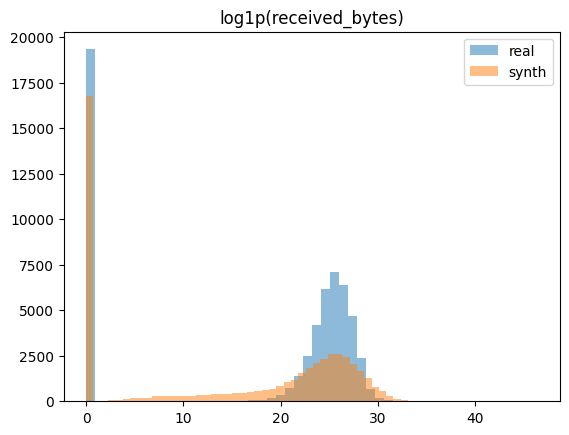

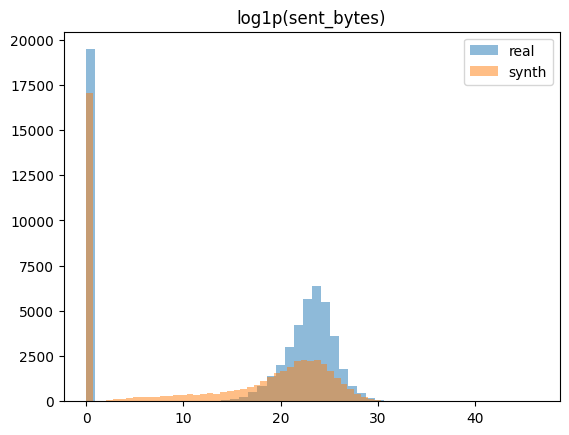

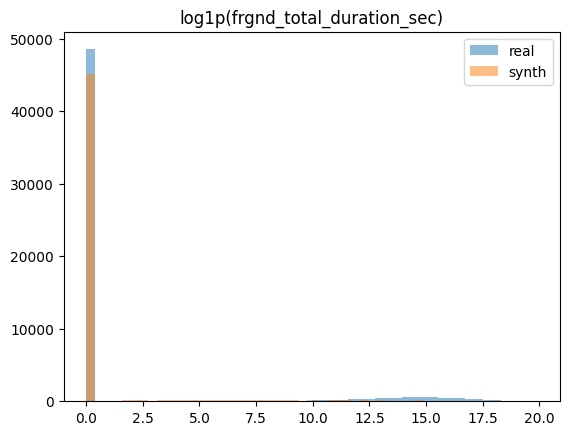

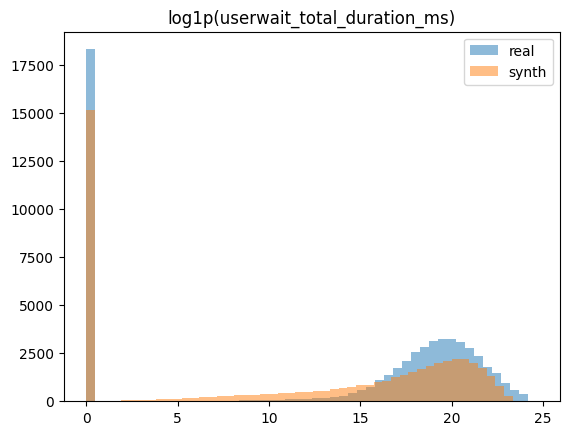

In [6]:
import matplotlib.pyplot as plt

def plot_log_hist(col):
    r = pd.to_numeric(real[col], errors="coerce").dropna()
    s = pd.to_numeric(synth[col], errors="coerce").dropna()
    r = np.log1p(r.clip(lower=0))
    s = np.log1p(s.clip(lower=0))

    plt.figure()
    plt.hist(r, bins=50, alpha=0.5, label="real")
    plt.hist(s, bins=50, alpha=0.5, label="synth")
    plt.title(f"log1p({col})")
    plt.legend()
    plt.show()

for c in ["received_bytes", "sent_bytes", "frgnd_total_duration_sec", "userwait_total_duration_ms"]:
    if c in real.columns and c in synth.columns:
        plot_log_hist(c)